# INTRO TO VAE

In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np

## PREPARE MNIST DATA

In [3]:
batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.Lambda(lambda x: x.view(-1) - 0.5),
    v2.Lambda(lambda x: x.view(-1))
])

# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [4]:
train_data[0][0].shape

torch.Size([784])

## AE 

### ENCODER

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(in_features=input_dim, out_features=64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=64, out_features=latent_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### DECODER

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(in_features=latent_dim, out_features=64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=64, out_features=output_dim)

    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z

### Vanilla AE

In [7]:
class AE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(AE, self).__init__()

        self.Encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.Decoder = Decoder(latent_dim=latent_dim, output_dim=output_dim)

    def forward(self, x):
        z = self.Encoder(x)
        output = self.Decoder(z)
        return output        

#### TRAINING 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_dim=28*28, latent_dim=2, output_dim=28*28).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.0670
Epoch 2, Loss: 0.0533
Epoch 3, Loss: 0.0512
Epoch 4, Loss: 0.0498
Epoch 5, Loss: 0.0490
Epoch 6, Loss: 0.0484
Epoch 7, Loss: 0.0480
Epoch 8, Loss: 0.0476
Epoch 9, Loss: 0.0472
Epoch 10, Loss: 0.0470
Epoch 11, Loss: 0.0467
Epoch 12, Loss: 0.0464
Epoch 13, Loss: 0.0462
Epoch 14, Loss: 0.0460
Epoch 15, Loss: 0.0458
Epoch 16, Loss: 0.0456
Epoch 17, Loss: 0.0454
Epoch 18, Loss: 0.0452
Epoch 19, Loss: 0.0451
Epoch 20, Loss: 0.0449


#### AE Latent space

In [9]:
def plot_latent(model, data_loader, num_batches=100):
    model.eval() 
    plt.figure(figsize=(8, 6))

    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device)
            if isinstance (model, AE):
                z = model.Encoder(x)  
            elif isinstance(model, VAE):
                z, _ = model.Encoder(x)
            
            z = z.cpu().numpy()
            y = y.numpy()

            if z.shape[1] >= 2:  # Check if latent dim >= 2
                plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
            
            if i >= num_batches:
                break

    plt.colorbar()
    plt.title("Latent Space Projection")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid(True)
    plt.show()

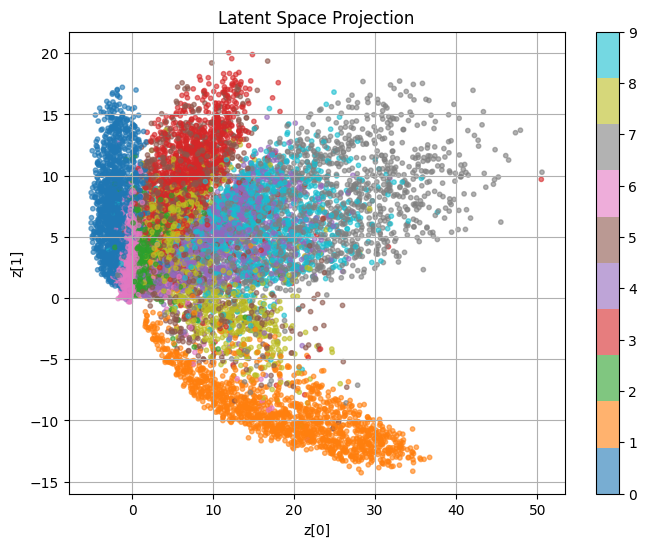

In [10]:
plot_latent(model, train_loader)

#### AE RESULTS

In [11]:
def plot_reconstructed(model, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.Decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])


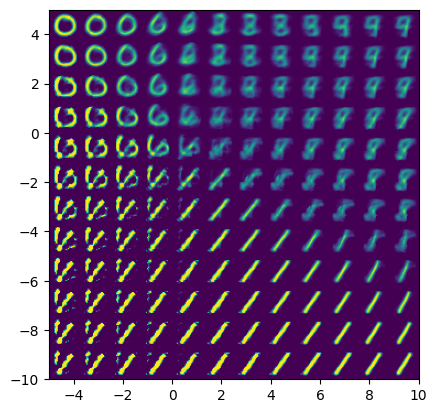

In [12]:
plot_reconstructed(model)

## VAE

### AE vs VAE

![alt text](<images/ae vs vae.png>)

### Latent vector

![alt text](<images/vae latent vector maping.png>)

### Standard normal distribution

![alt text](<images/Standard normal distribution.png>)

### Reparameterization trick

![alt text](<images/reparameterization trick.png>)

### VARIATIONAL ENCODER

In [13]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        
        self.fc1 = nn.Linear(in_features=input_dim, out_features=64)
        self.relu = nn.ReLU()
        # Layer for μ (mean vector of the latent distribution)
        self.fc2 = nn.Linear(64, latent_dim)
        # Layer for σ (deviation)
        self.fc3 = nn.Linear(64, latent_dim)

        #Normal distribution
        self.N = torch.distributions.Normal(0,1)

    def forward(self, x):
        x = self.relu(self.fc1(x))

        # Środek (średnia) wektora latent dla próbki
        mu = self.fc2(x)
        
        # Logarytm odchylenia standardowego wektora latent
        log_sigma = self.fc3(x)
        # Odchylenie standardowe (sigma) – zapewniamy, że wartości są dodatnie
        sigma = torch.exp(log_sigma)

        # Random sample from N(0,1)
        epsilon = torch.randn_like(mu)

        # Final latent (sigma * epsilon to rozciągnięcie randomowego sampla na odchylenie standardowe)
        z = mu + sigma * epsilon

        # KL Divergence (jak odbiega z(mu,sigma) od N(0,1))
        KL =  0.5 * torch.sum(sigma**2 + mu**2 - 2*log_sigma - 1)

        return z, KL


### DECODER

In [ ]:
# Decoder is the same as in the vanilla AE

### VAE

In [15]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(VAE, self).__init__()

        self.Encoder = VariationalEncoder(input_dim = input_dim, latent_dim=latent_dim)
        self.Decoder = Decoder(latent_dim=latent_dim, output_dim=output_dim)

    def forward(self, x):
        z, KL = self.Encoder(x) 
        reconstructed = self.Decoder(z)
        return reconstructed, KL

#### TRAINING

##### Loss function

![alt text](<images/vae loss explanation.png>)

In [3]:
def vae_loss(x, reconstructed_x, KL, loss_type):
    # Reconstruction loss
    if loss_type == "BCE":
        reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    elif loss_type == "MSE":
        reconstruction_loss = ((x - reconstructed_x)**2).sum() # MSE
    
    full_loss = reconstruction_loss + KL
    return full_loss

#TODO sprawdzic loss reconstruction vs kl 
# logowanie lossa do cometa

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=28*28, latent_dim=2, output_dim=28*28).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = vae_loss

for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed_images, KL = model(images)
        loss = loss_fn(images, reconstructed_images, KL, loss_type="MSE")
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 7568.1330
Epoch 2, Loss: 5880.4322
Epoch 3, Loss: 5622.9324
Epoch 4, Loss: 5522.8664
Epoch 5, Loss: 5450.9842
Epoch 6, Loss: 5391.7501
Epoch 7, Loss: 5346.0499
Epoch 8, Loss: 5303.9020
Epoch 9, Loss: 5269.1377
Epoch 10, Loss: 5241.9196
Epoch 11, Loss: 5218.5331
Epoch 12, Loss: 5195.0176
Epoch 13, Loss: 5173.4378
Epoch 14, Loss: 5153.4996
Epoch 15, Loss: 5136.8733
Epoch 16, Loss: 5121.7270
Epoch 17, Loss: 5106.2894
Epoch 18, Loss: 5092.8650
Epoch 19, Loss: 5079.2736
Epoch 20, Loss: 5070.9736


#### VAE LATENT SPACE

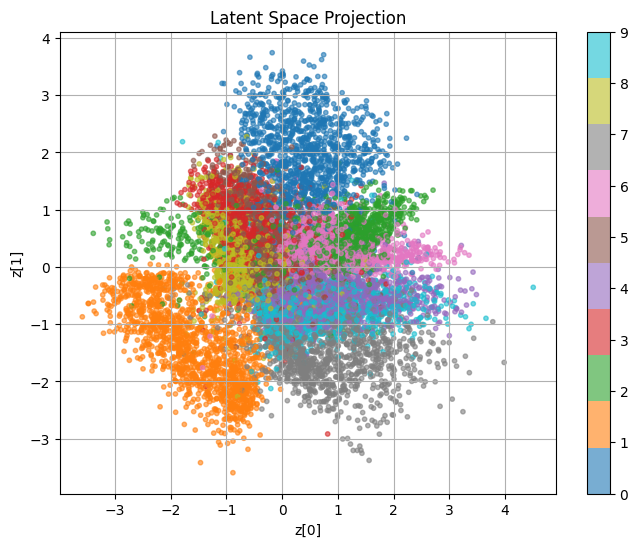

In [18]:
plot_latent(model, train_loader)

#### VAE RESULTS

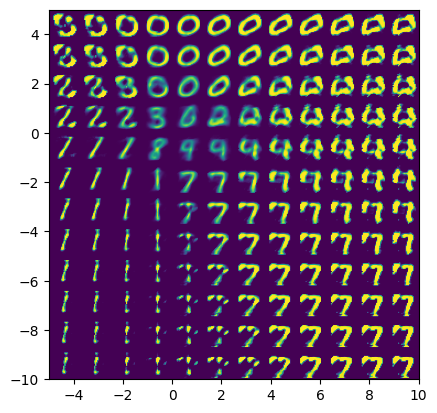

In [19]:
plot_reconstructed(model)

# LINKS

https://avandekleut.github.io/vae/<br>
https://github.com/williamcfrancis/Variational-Autoencoder-for-MNIST/blob/main/VAE_Digit_Recognition.ipynb